In [64]:
from collections import Counter
import re

import hdbscan
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import umap
from sklearn.preprocessing import StandardScaler

import mgitools.os_helpers as os_helpers

## imaging

In [65]:
outputs_dir = '/Users/erikstorrs/Documents/ding/cell-segmentation/outputs/'

In [66]:
# grab rois cells
fps = []
for fp in os_helpers.listfiles(outputs_dir):
    if '.tsv' in fp:
        fps.append(fp)
fps

['/Users/erikstorrs/Documents/ding/cell-segmentation/outputs/F_1199_07_P001/figures/cell_intensities.tsv',
 '/Users/erikstorrs/Documents/ding/cell-segmentation/outputs/F_1199_07_P006/figures/cell_intensities.tsv',
 '/Users/erikstorrs/Documents/ding/cell-segmentation/outputs/F_1199_07_P000/figures/cell_intensities.tsv',
 '/Users/erikstorrs/Documents/ding/cell-segmentation/outputs/F_1199_07_P005/figures/cell_intensities.tsv',
 '/Users/erikstorrs/Documents/ding/cell-segmentation/outputs/F_1199_07_P002/figures/cell_intensities.tsv',
 '/Users/erikstorrs/Documents/ding/cell-segmentation/outputs/F_1199_07_P003/figures/cell_intensities.tsv',
 '/Users/erikstorrs/Documents/ding/cell-segmentation/outputs/F_1199_07_P004/figures/cell_intensities.tsv']

In [67]:
data = []
cell_ids = []
columns = []
rois = []

for fp in sorted(fps):
    f = open(fp)
    columns = f.readline().strip().split('\t')
    for line in f:
        pieces = line.strip().split('\t')
        cell_ids.append(pieces[0])
        data.append([float(x) for x in pieces[1:]])
        rois.append(re.sub(r'^.*outputs/(.*)/figures.*$', r'\1', fp))
    f.close()

In [68]:
X = np.asarray(data)

In [69]:
X.shape

(20160, 12)

In [70]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [71]:
X_embedded = umap.UMAP(
    n_neighbors=15,
    min_dist=0.0,
    n_components=2,
    random_state=42,
).fit_transform(X)

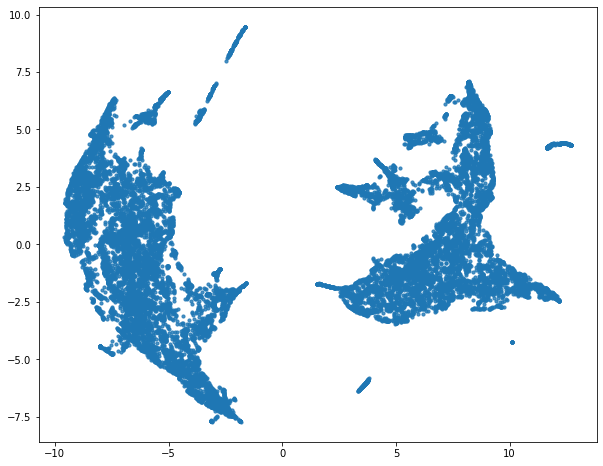

In [72]:
plt.figure(figsize=(10,8))
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], alpha = .8, s=10)

In [73]:
labels = hdbscan.HDBSCAN(
    min_samples=50,
    min_cluster_size=50,
).fit_predict(X_embedded)

/Users/erikstorrs/miniconda3/lib/python3.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/Users/erikstorrs/miniconda3/lib/python3.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/Users/erikstorrs/miniconda3/lib/python3.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/Users/erikstorrs/miniconda3/lib/python3.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)


In [74]:
print(X_embedded.shape, len(cell_ids))

(20160, 2) 20160


In [75]:
plotting_df = pd.DataFrame(data=X_embedded, columns=['UMAP1', 'UMAP2'], index=cell_ids)
# for c in sc_df.columns:
#     plotting_df[c] = list(sc_df[c])
plotting_df['cluster'] = labels
plotting_df['roi'] = rois

for i, c in enumerate(columns):
    ls = X[:, i]
    plotting_df[c] = list(ls)

plotting_df = plotting_df.sample(frac=1)

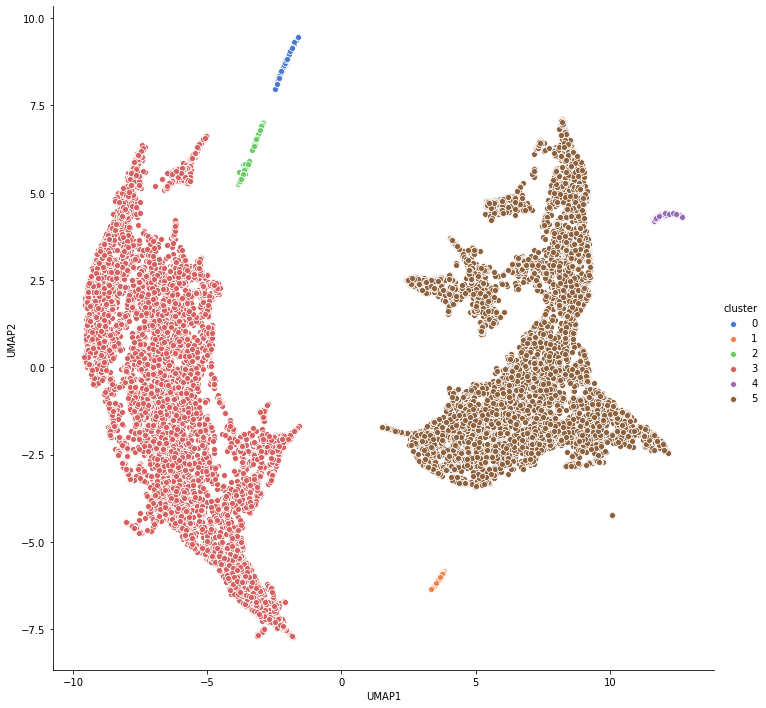

In [76]:
axs = sns.pairplot(plotting_df, x_vars=['UMAP1'], y_vars=['UMAP2'], hue='cluster', height=10,
                  palette='muted')

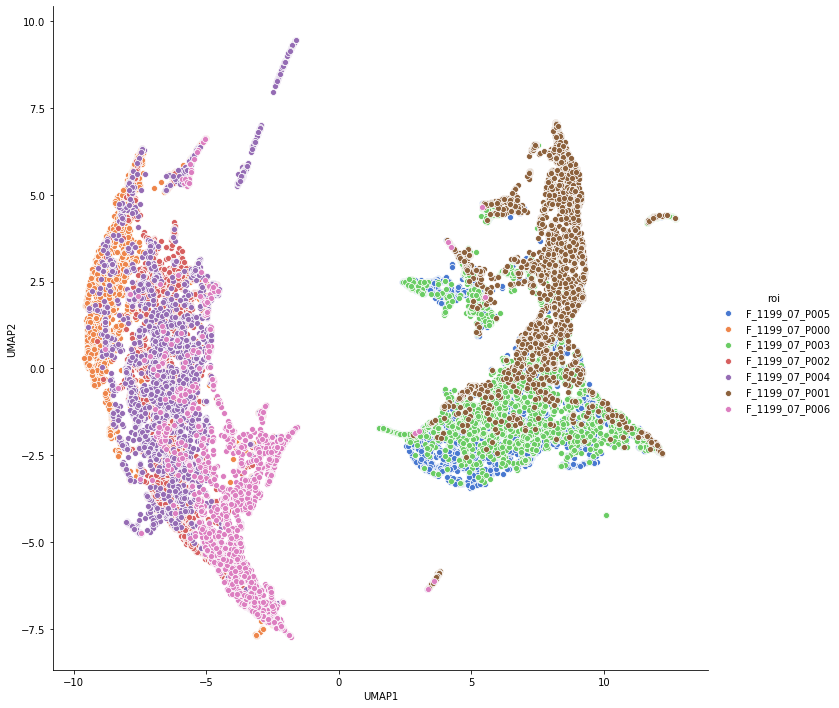

In [77]:
axs = sns.pairplot(plotting_df, x_vars=['UMAP1'], y_vars=['UMAP2'], hue='roi', height=10,
                  palette='muted')

Ki67


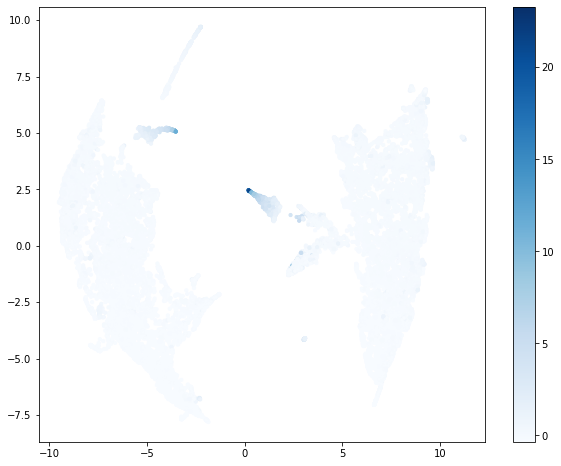

CD3


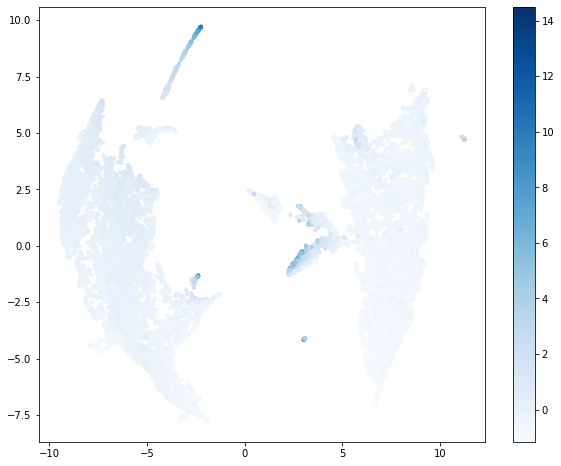

CD20


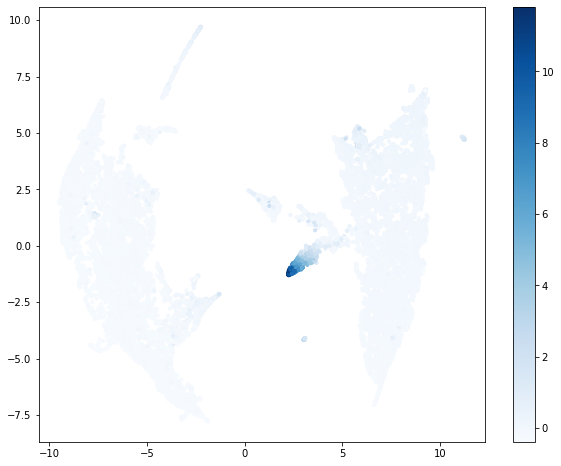

PDL1


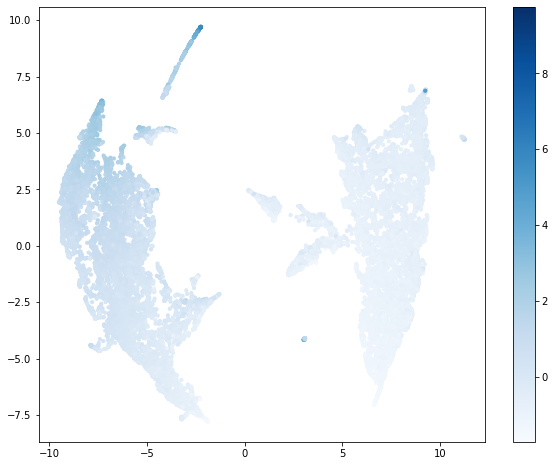

CD56


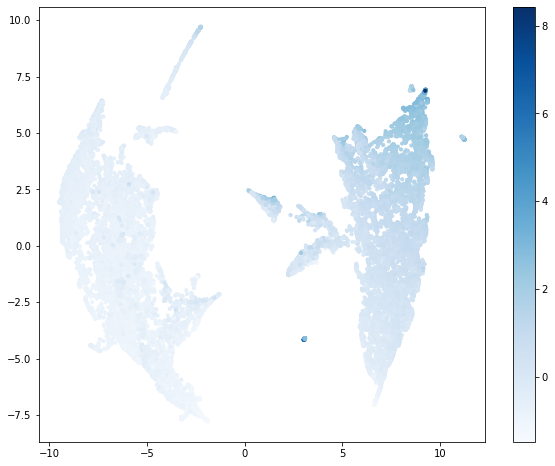

CD8


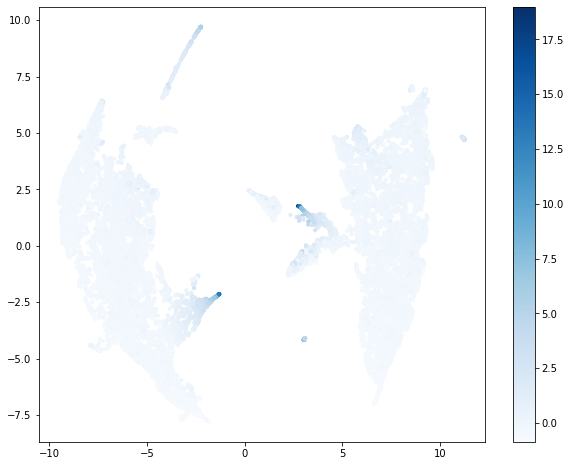

PD1


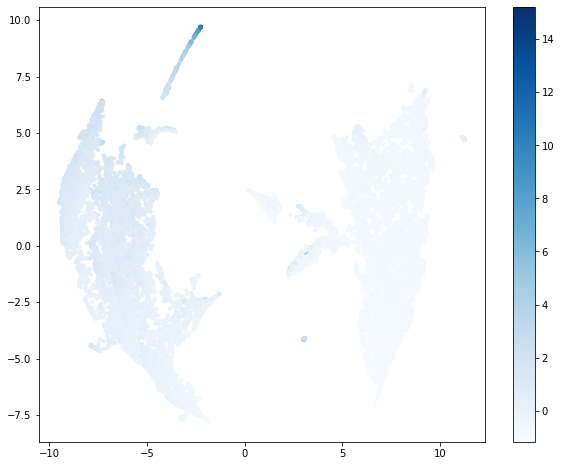

SOX10


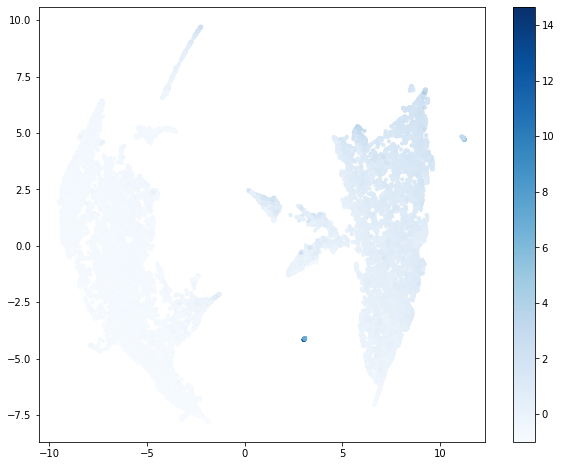

CD68


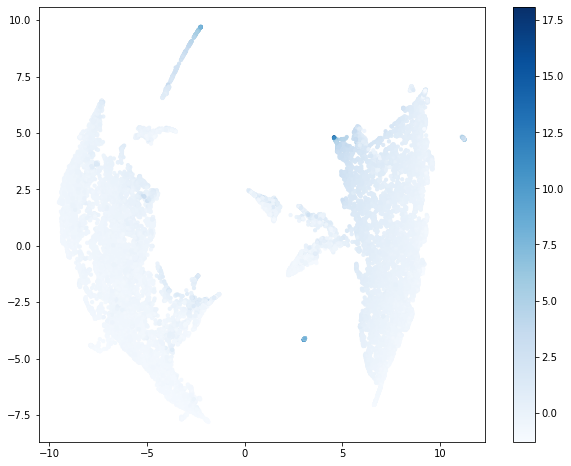

CD45


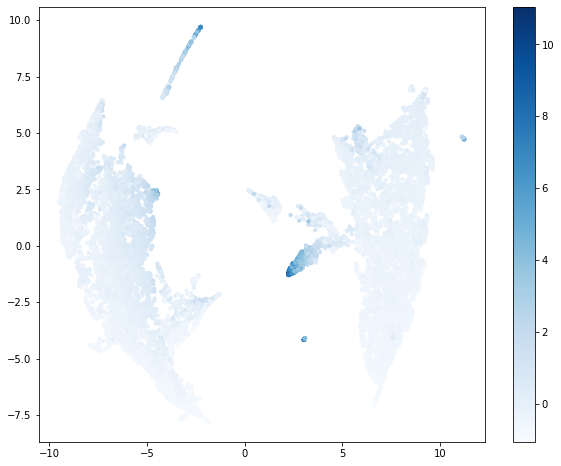

FOXP3


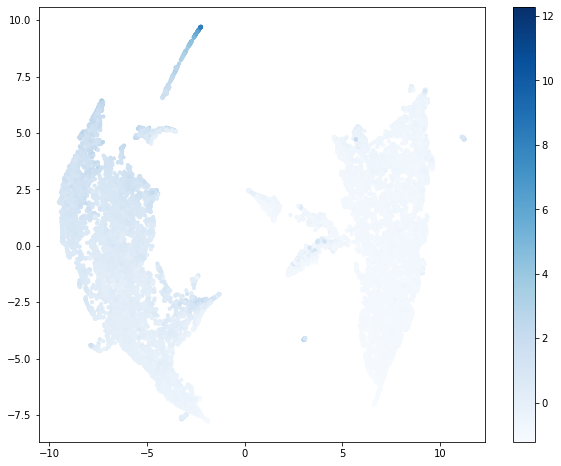

CD4


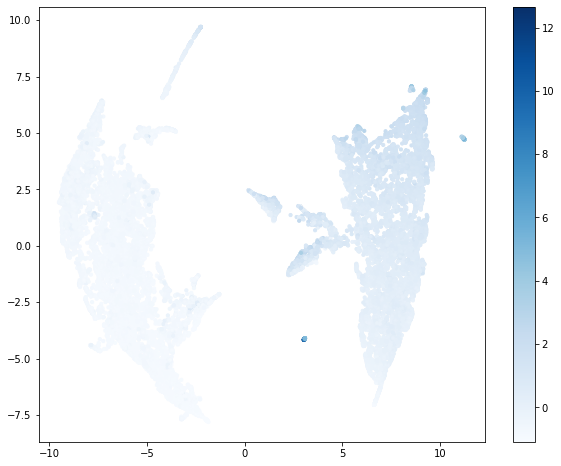

In [63]:
for i, c in enumerate(columns):
    ls = X[:, i]
    print(c)
    plotting_df[c] = list(ls)
    plt.figure(figsize=(10,8))
    plt.scatter(plotting_df.UMAP1, plotting_df.UMAP2, alpha=1., c=plotting_df[c],  cmap='Blues', s=10)
    cbar = plt.colorbar()
    plt.show()

## single cell

In [ ]:
gene_table_fp = '/Users/erikstorrs/Downloads/mart_export.txt'
gene_df = pd.read_csv(gene_table_fp, sep='\t')
gene_df.head()

In [ ]:
gene_id_to_gene_name = {r['Gene stable ID']:r['Gene name'] for i, r in gene_df.iterrows()}

In [ ]:
input_fp = '/Users/erikstorrs/Documents/ding/cell-segmentation/data/scRNA/normalized_exp_1199_07.txt'

In [ ]:
sc_df = pd.read_csv(input_fp, sep='\t')

In [ ]:
sc_df.head()

In [ ]:
# remove genes with high missingness
idxs = []
for i, (idx, row) in enumerate(sc_df.iterrows()):
    if i % 5000 == 0:
        print(i)
        
    c = Counter(list([int(x) for x in row]))
    if c[0] == int(sc_df.shape[1]):
        idxs.append(idx)

In [ ]:
len(idxs)

In [ ]:
sc_df = sc_df.drop(idxs)

In [ ]:
sc_df.head()

In [ ]:
sc_df = sc_df.transpose()
sc_df.head()

In [ ]:
# replace columns with gene names
cs = [gene_id_to_gene_name.get(c, c) for c in sc_df.columns]
sc_df.columns = cs

In [ ]:
sc_df.shape

In [ ]:
sc_df.head()

In [ ]:
X = np.copy(sc_df.values)

In [ ]:
X_embedded = umap.UMAP(
    n_neighbors=15,
    min_dist=0.0,
#     n_components=20,
    n_components=50,

    random_state=42,
).fit_transform(X)

In [ ]:
labels = hdbscan.HDBSCAN(
    min_samples=50,
    min_cluster_size=50,
).fit_predict(X_embedded)

In [ ]:
X_embedded = umap.UMAP(
    n_neighbors=15,
    min_dist=0.0,
    n_components=2,
    random_state=42,
).fit_transform(X_embedded)

In [ ]:
plotting_df = pd.DataFrame(data=X_embedded, columns=['UMAP1', 'UMAP2'], index=sc_df.index)
# for c in sc_df.columns:
#     plotting_df[c] = list(sc_df[c])
plotting_df['cluster'] = labels

In [ ]:
plt.figure(figsize=(10,8))
plt.scatter(plotting_df.UMAP1, plotting_df.UMAP2, alpha = .8, s=10)

In [ ]:
axs = sns.pairplot(plotting_df, x_vars=['UMAP1'], y_vars=['UMAP2'], hue='cluster', height=10,
                  palette='muted')
# plt.savefig(os.path.join(output_figures_dir, 'clustered_cells.png'), dpi=1000)

In [ ]:
c = 'SOX10'

plotting_df[c] = list(sc_df[c])
plt.figure(figsize=(10,8))
plt.scatter(plotting_df.UMAP1, plotting_df.UMAP2, alpha=1., c=plotting_df[c],  cmap='Blues', s=10)
cbar = plt.colorbar()

In [ ]:
c = 'CD3G'

plotting_df[c] = list(sc_df[c])
plt.figure(figsize=(10,8))
plt.scatter(plotting_df.UMAP1, plotting_df.UMAP2, alpha=1., c=plotting_df[c],  cmap='Blues', s=10)
cbar = plt.colorbar()

In [ ]:
c = 'CD4'

plotting_df[c] = list(sc_df[c])
plt.figure(figsize=(10,8))
plt.scatter(plotting_df.UMAP1, plotting_df.UMAP2, alpha=1., c=plotting_df[c],  cmap='Blues', s=10)
cbar = plt.colorbar()

In [ ]:
c = 'CD8A'

plotting_df[c] = list(sc_df[c])
plt.figure(figsize=(10,8))
plt.scatter(plotting_df.UMAP1, plotting_df.UMAP2, alpha=1., c=plotting_df[c],  cmap='Blues', s=10)
cbar = plt.colorbar()

In [ ]:
# cd20
c = 'MS4A1'

plotting_df[c] = list(sc_df[c])
plt.figure(figsize=(10,8))
plt.scatter(plotting_df.UMAP1, plotting_df.UMAP2, alpha=1., c=plotting_df[c],  cmap='Blues', s=10)
cbar = plt.colorbar()

In [ ]:
# cd45
c = 'PTPRC'

plotting_df[c] = list(sc_df[c])
plt.figure(figsize=(10,8))
plt.scatter(plotting_df.UMAP1, plotting_df.UMAP2, alpha=1., c=plotting_df[c],  cmap='Blues', s=10)
cbar = plt.colorbar()

In [ ]:
# cd56
c = 'NCAM1'

plotting_df[c] = list(sc_df[c])
plt.figure(figsize=(10,8))
plt.scatter(plotting_df.UMAP1, plotting_df.UMAP2, alpha=1., c=plotting_df[c],  cmap='Blues', s=10)
cbar = plt.colorbar()

In [ ]:
c = 'CD68'

plotting_df[c] = list(sc_df[c])
plt.figure(figsize=(10,8))
plt.scatter(plotting_df.UMAP1, plotting_df.UMAP2, alpha=1., c=plotting_df[c],  cmap='Blues', s=10)
cbar = plt.colorbar()

In [ ]:
c = 'FOXP3'

plotting_df[c] = list(sc_df[c])
plt.figure(figsize=(10,8))
plt.scatter(plotting_df.UMAP1, plotting_df.UMAP2, alpha=1., c=plotting_df[c],  cmap='Blues', s=10)
cbar = plt.colorbar()

In [ ]:
# pdl1
c = 'CD274'

plotting_df[c] = list(sc_df[c])
plt.figure(figsize=(10,8))
plt.scatter(plotting_df.UMAP1, plotting_df.UMAP2, alpha=1., c=plotting_df[c],  cmap='Blues', s=10)
cbar = plt.colorbar()

In [ ]:
# pd1
c = 'PDCD1'

plotting_df[c] = list(sc_df[c])
plt.figure(figsize=(10,8))
plt.scatter(plotting_df.UMAP1, plotting_df.UMAP2, alpha=1., c=plotting_df[c],  cmap='Blues', s=10)
cbar = plt.colorbar()

In [ ]:
# ki-67
c = 'MKI67'

plotting_df[c] = list(sc_df[c])
plt.figure(figsize=(10,8))
plt.scatter(plotting_df.UMAP1, plotting_df.UMAP2, alpha=1., c=plotting_df[c],  cmap='Blues', s=10)
cbar = plt.colorbar()

In [ ]:
keep = ['SOX10', 'CD3G', 'CD4', 'CD8A', 'MS4A1', 'PTPRC', 'NCAM1', 'CD68', 'FOXP3', 'CD274', 'PDCD1', 'MKI67']

In [ ]:
integrated_df = sc_df[keep]
integrated_df.head()

In [ ]:
X = np.copy(integrated_df.values)

In [ ]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [ ]:
X_embedded = umap.UMAP(
    n_neighbors=100,
    min_dist=0.,
    n_components=2,

    random_state=42,
).fit_transform(X)

In [ ]:
labels = hdbscan.HDBSCAN(
    min_samples=50,
    min_cluster_size=50,
).fit_predict(X_embedded)

In [ ]:
plotting_df = pd.DataFrame(data=X_embedded, columns=['UMAP1', 'UMAP2'], index=sc_df.index)
# for c in sc_df.columns:
#     plotting_df[c] = list(sc_df[c])
plotting_df['cluster'] = labels

In [ ]:
axs = sns.pairplot(plotting_df, x_vars=['UMAP1'], y_vars=['UMAP2'], hue='cluster', height=10,
                  palette='muted')

In [ ]:
for c in keep:
    print(c)
    plotting_df[c] = list(sc_df[c])
    plt.figure(figsize=(10,8))
    plt.scatter(plotting_df.UMAP1, plotting_df.UMAP2, alpha=1., c=plotting_df[c],  cmap='Blues', s=10)
    cbar = plt.colorbar()
    plt.show()